# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Outlines  
### Part 1: Customer Segmentation Report
#### 1.1  Define all functions that will be used in this project  
  
#### 1.2 Preprocessing of population dataset 
  * 1.2.1 Load data and fix problems  
  * 1.2.2 Assess unknown data in columns and rows, and replace them with NaN
  * 1.2.3 Remove columns with more than 30% missing values and rows with more than 20% of missing values
  * 1.2.4 Re-engineer features
  * 1.2.5 Re-encode object features
  * 1.2.6 Build a cleaning function for cleaning customer data 
  
#### 1.3 Primary component analysis (PCA) and K-means clustering of population dataset  
  * 1.3.1 Imputation, feature selection and scaling  
  * 1.3.2 Apply PCA  
  * 1.3.3 Apply K-means clustering  
      
#### 1.4 Apply the same procedure on Customer datasest  
   
#### 1.5 Compare customer cluster to population cluster and obtain the demographic characteristics of potential customers

### Part 2: Supervised Learning Model
#### 2.1 Define all functions that will be used in this project  

#### 2.2 Split data into training and testing data  

#### 2.3 Select classifers and train models with default parameters

#### 2.4 Fine tune parameters
  * 2.4.1 Fine tune parameters for XGBRegressor
  * 2.4.2 Fine tune parameters for GradientBoostingRegressor


In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from numpy import nan
import time

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Define all functions that will be used in this project

In [2]:
def fill_na(df, col):
    '''
    Fill in the blank cell with the last valid observation
    
    Keyword arguments:
    df: dataframe
    col: column name
    
    Returns:
    dataframe with filled value
    
    '''
    df[col].fillna(method = 'ffill', inplace = True)
    return df

In [3]:
# check values in azdias to see if there are abnormal values that were not defined in the feature_info table and replace it to NaN
def replace_no_meaning_value_with_nan(data, feature_doc):
    '''
    replace values in data sheet that were not described in the feature information spreadsheet with NaN
    
    Keyword arguments:
    data: data record
    feature_doc: feature information spreadsheet
    
    Returns:
    data with no meaning values replaced by NaN
    
    '''
    attribute_in_data = list(data.columns)
    attribute_in_feature = list(feature_doc['Attribute'].unique())
    shared_attribute = [value for value in attribute_in_data if value in attribute_in_feature]
    
    for attribute in shared_attribute:
        tempDf = data[[attribute]].dropna(axis=0)
        unique_values_in_data = set(tempDf[attribute])
        values_described_in_feature = set(feature_doc.loc[feature_doc.Attribute == attribute, 'Value'])
        values_no_meaning = list(unique_values_in_data - values_described_in_feature)
        if len(values_no_meaning) == 0:
            continue
        data[attribute] = data[attribute].apply(lambda x: np.nan if x in values_no_meaning else x)
        
    return data

In [4]:
# Identify missing or unknown data values documented in feature_info table and convert them to NaNs.
def replace_unknown_value_with_nan(data, feature_doc):
    '''
    Find unknown values in data sheet that were defined in the feature information spreadsheet and replace them with NaN
    
    Keyword arguments:
    data: data sheet
    feature_doc: feature information spreadsheet
    
    Returns:
    data with unknown values replaced by NaN
    
    '''
    #cols = data.columns.values
    cols = data.columns

    for colName in cols:
        na_values=feature_doc[(feature_doc.Attribute == colName) & (feature_doc.Meaning.str.contains('unknown|no transactions known'))].Value.tolist()   
        data[colName] = data[colName].apply(lambda x: np.nan if x in na_values else x)
        
    return data

In [5]:
#Once we find the columns we need to remove from azdias dataset, we need to remove the same columns from the 
#other datasets, such as the customer dataset; we also need to rows with more than 30 of missing values
def remove_columns_rows_by_NA_counts(data, azdias_rm_col):
    '''
    Remove the same columns from the customer dataset as we did in azdias; Rmoeve rows with more than 30 missing values
    
    Keyword arguments:
    data: data sheet
    azdias_rm_col: columns removed from azdias dataset
    
    Returns:
    data with columns and rows cleaned
    '''
    data_column_filtered = data.drop(azdias_rm_col, axis=1) #drop the same columns as we did in azdias
    #data_column_filtered['na_by_row'] = data_column_filtered.isnull().sum(axis=1)
    #data_row_column_filtered = data_column_filtered[data_column_filtered['na_by_row'] /data_column_filtered.shape[1] < 0.2]
    naCounts_by_row = data_column_filtered.isnull().sum(axis=1)
    data_column_filtered['naPercentage_by_row'] = naCounts_by_row/data_column_filtered.shape[1]
    data_column_row_filtered = data_column_filtered[data_column_filtered['naPercentage_by_row'] < 0.2] #extract rows with less than 30 missing data for further analysis
    data_column_row_filtered = data_column_row_filtered.drop('naPercentage_by_row', axis = 1)

    return data_column_row_filtered

In [6]:
#"CAMEO_INTL_2015" and "PRAEGENDE_JUGENDJAHRE" features contain two types of information, so we split the columns
# to two columns
def split_CAMEO_INTL_2015(data):
    '''
    Split "CAMEO_INTL_2015" feature into two columns
    
    Keyword arguments:
    data: data sheet

    Returns:
    data with "CAMEO_INTL_2015" feature splited into "CAMEO_INTL_2015_wealth" and "CAMEO_INTL_2015_life" columns
    '''
    
    CAMEO_INTL_2015_wealth = []
    CAMEO_INTL_2015_life = []
    for row in data['CAMEO_INTL_2015']:
        if math.isnan(float(row)):
            CAMEO_INTL_2015_wealth.append(np.nan)
            CAMEO_INTL_2015_life.append(np.nan)
        else:
            CAMEO_INTL_2015_wealth.append(int(int(row)/10))
            CAMEO_INTL_2015_life.append(int(row)%10)

    data['CAMEO_INTL_2015_wealth'] = CAMEO_INTL_2015_wealth
    data['CAMEO_INTL_2015_life'] = CAMEO_INTL_2015_life

    data.drop(['CAMEO_INTL_2015'], axis=1, inplace = True)
    
    
def split_PRAEGENDE_JUGENDJAHRE(data):
    '''
    Split "PRAEGENDE_JUGENDJAHRE" feature into two columns
    
    Keyword arguments:
    data: data sheet

    Returns:
    data with "PRAEGENDE_JUGENDJAHRE" feature splited into "PRAEGENDE_JUGENDJAHRE_decade" and "PRAEGENDE_JUGENDJAHRE_movement" columns
    '''
    PRAEGENDE_JUGENDJAHRE_decade = []

    for row in data['PRAEGENDE_JUGENDJAHRE']:
        if row in [1, 2]:
            PRAEGENDE_JUGENDJAHRE_decade.append(1)
        elif row in [3, 4]:
            PRAEGENDE_JUGENDJAHRE_decade.append(2)
        elif row in [5, 6, 7]:
            PRAEGENDE_JUGENDJAHRE_decade.append(3)
        elif row in [8, 9]:
            PRAEGENDE_JUGENDJAHRE_decade.append(4)    
        elif row in [10, 11, 12, 13]:
            PRAEGENDE_JUGENDJAHRE_decade.append(5)
        elif row in [14, 15]:
            PRAEGENDE_JUGENDJAHRE_decade.append(6)
        else:
            PRAEGENDE_JUGENDJAHRE_decade.append(np.nan)

    data['PRAEGENDE_JUGENDJAHRE_decade'] = PRAEGENDE_JUGENDJAHRE_decade

    PRAEGENDE_JUGENDJAHRE_movement = []
    for row in data['PRAEGENDE_JUGENDJAHRE']:
        if row in [1, 3, 5, 8, 10, 12, 14]:
            PRAEGENDE_JUGENDJAHRE_movement.append(0)
        elif row in [2, 4, 6, 7, 9, 11, 13, 15]:
            PRAEGENDE_JUGENDJAHRE_movement.append(1)
        else:
            PRAEGENDE_JUGENDJAHRE_movement.append(np.nan)
 
    data['PRAEGENDE_JUGENDJAHRE_movement'] = PRAEGENDE_JUGENDJAHRE_movement
    
    PRAEGENDE_JUGENDJAHRE_nation = []
    for row in data['PRAEGENDE_JUGENDJAHRE']:
        if row in [1, 2, 3, 4, 5, 8, 9, 14, 15]:
            PRAEGENDE_JUGENDJAHRE_nation.append(0)
        elif row in [7, 12, 13]:
            PRAEGENDE_JUGENDJAHRE_nation.append(1)
        else:
            PRAEGENDE_JUGENDJAHRE_nation.append(2)
 
    data['PRAEGENDE_JUGENDJAHRE_nation'] = PRAEGENDE_JUGENDJAHRE_nation

    data.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True) 

In [7]:
# Some values in "LP_STATUS_GROB" and "LP_FAMILIE_GROB" features have the same meaning, so these two functions 
#are to combine values with the same meaning to one value in these two features.
def engineer_LP_STATUS_GROB(data):
    '''
    Engineer "LP_STATUS_GROB" to combine values with the same meaning
    
    Keyword arguments:
    data: data sheet

    Returns:
    data with "LP_STATUS_GROB" feature re-engineered
    '''
    
    LP_STATUS_GROB_engineered = []

    for row in data['LP_STATUS_GROB']:
        if row in [1, 2]:
            LP_STATUS_GROB_engineered.append(1)
        elif row in [3, 4, 5]:
            LP_STATUS_GROB_engineered.append(2)
        elif row in [6, 7]:
            LP_STATUS_GROB_engineered.append(3)
        elif row in [8, 9]:
            LP_STATUS_GROB_engineered.append(4)
        elif row in [10]:
            LP_STATUS_GROB_engineered.append(5)
        else:
            LP_STATUS_GROB_engineered.append(np.nan)

    data['LP_STATUS_GROB_engineered'] = LP_STATUS_GROB_engineered
    data.drop(['LP_STATUS_GROB'], axis=1, inplace=True)\

      
    
def engineer_LP_FAMILIE_GROB(data):
    '''
    Engineer "LP_FAMILIE_GROB" to combine values with the same meaning
    
    Keyword arguments:
    data: data sheet

    Returns:
    data with "LP_FAMILIE_GROB" feature re-engineered
    '''
    LP_FAMILIE_GROB_engineered = []

    for row in data['LP_FAMILIE_GROB']:
        if row in [3, 4, 5]:
            LP_FAMILIE_GROB_engineered.append(3)
        elif row in [6, 7, 8]:
            LP_FAMILIE_GROB_engineered.append(4)
        elif row in [9, 10, 11]:
            LP_FAMILIE_GROB_engineered.append(5)
        else:
            LP_FAMILIE_GROB_engineered.append(row)

    data['LP_FAMILIE_GROB_engineered'] = LP_FAMILIE_GROB_engineered
    data.drop(['LP_FAMILIE_GROB'], axis=1, inplace=True)

In [8]:
def histogram_plot(df):
    '''
    plot histogram
    
    Keyword arguments:
    df: data sheet

    Returns:
    histogram plot
    '''
    
    fig = df.hist(bins=10, figsize = (20,10))
    params = {'axes.titlesize':'6',
              'xtick.labelsize':'6',
              'ytick.labelsize':'6'}
    matplotlib.rcParams.update(params)
    plt.show()

In [9]:
def waitForSecs(secs):
    for i in range(1, secs):
        time.sleep(1)

In [10]:
#remove columns that have correlation higher than 0.9
#corr = azdias_nan_filled.corr()
def remove_high_correlated_columns(corr, data):
    columns = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >= 0.9:
                if columns[j]:
                    columns[j] = False
    low_correlated_columns = data.columns[columns]
    data = data[low_correlated_columns]

    return data

### 1.2 Preprocessing of population dataset 
#### 1.2.1 Load data and fix problems 
  
There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [11]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=';')

/Users/maoshaohua/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [13]:
azdias.shape

(891221, 366)

In [14]:
#column 18 and 19 have mixed values, check the values and fix the problem.
print(azdias.iloc[:,18].value_counts())
print(azdias.iloc[:,19].value_counts())

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64
51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64


In [15]:
# replace "x", "xx" with NaN, and set the data type to float
COL_CAMEO_DEUG_2015 = 'CAMEO_DEUG_2015'
COL_CAMEO_INTL_2015 = 'CAMEO_INTL_2015'

azdias[COL_CAMEO_DEUG_2015] = azdias[COL_CAMEO_DEUG_2015].astype(str).replace({'X':np.nan}).astype(float)
azdias[COL_CAMEO_INTL_2015] = azdias[COL_CAMEO_INTL_2015].astype(str).replace({'XX':np.nan}).astype(float)

# Drop column 'LNR'
azdias.drop(['LNR'], axis=1, inplace=True)

In [16]:
#read in feature spreadsheet, these two sheets are multi-level indexed, so use fill_na function to fill the blank cells
attributes_describe = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx',header = 1, usecols = range(1,5))
attributes_describe = fill_na(attributes_describe, 'Information level')

feature_info = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', header = 1, usecols = range(1,6))
feature_info = fill_na(feature_info, 'Attribute')
feature_info = fill_na(feature_info, 'Description')

In [17]:
print(attributes_describe.shape)
attributes_describe.head()

(313, 4)


,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [18]:
print(feature_info.shape)
feature_info.head(10)

(2258, 4)


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


In [19]:
feature_info.Attribute.nunique()

314

In [20]:
# there are 313 attributes in the feature_info spreadsheet, but 366 in the azdias population, so there is inconsistent 
#between the azdias and feature_info spreadsheet
attributes_not_documented_in_feature_info = list(set(list(azdias.columns)) - set(list(attributes_describe['Attribute'])))
attributes_no_data_in_azdias =list(set(list(attributes_describe['Attribute'])) - set(list(azdias.columns)))

print('attributes that are included in azdias dataset, but not in attributes spreadsheet:', 
      len(attributes_not_documented_in_feature_info))
print('attributes that are included in attributes spreadsheet, but not in azdias dataset:', 
      len(attributes_no_data_in_azdias))

attributes that are included in azdias dataset, but not in attributes spreadsheet: 101
attributes that are included in attributes spreadsheet, but not in azdias dataset: 49


In [21]:
# Creat a new feature information datasheet with exactly the same attributes as in the azdias datasheet.
feature_info_reorganize = pd.DataFrame(columns = ['Attribute','Type'])
feature_info_reorganize['Attribute'] = azdias.columns
# because most of the attributes are ordinal data, so we assign "Ordinal" to all attributes at first
feature_info_reorganize['Type'] = 'ordinal' 

# Find numeric attribute that were marked in the original feature_info datasheet and revise the new 
# feature_info_reorganize datasheet accordingly
numeric_attributes = feature_info[feature_info.Meaning.str.contains('numeric', na=False)].Attribute.tolist()
feature_info_reorganize.loc[feature_info_reorganize['Attribute'].isin(numeric_attributes), 'Type'] = 'numeric'

print(numeric_attributes)
print(feature_info_reorganize['Type'].value_counts())
print(feature_info_reorganize.shape)

['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']
ordinal    358
numeric      7
Name: Type, dtype: int64
(365, 2)


In [22]:
feature_info_reorganize.to_csv("feature_info_reorganize.csv")
# manual curate the data type in the feature_info_reorganize csv file. For example, some attributes (e.g.LP_FAMILIE_FEIN) are not ordinal, 
# and need to be re-encoded later as categorical data


#### 1.2.2 Assess unknown data in columns and rows, and replace them with NaN

In [23]:
# replace values that were not defined in the feature_info table and replace it to NaN
azdias = replace_no_meaning_value_with_nan(azdias, feature_info)

# Identify missing or unknown data values documented in feature_info table and convert them to NaNs.
azdias = replace_unknown_value_with_nan(azdias, feature_info)

azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,NaN,NaN,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


##### Note: For attributes that were not documented in feature table, we can only assume that except 'NaN', there is no other unknown values 

In [24]:
attributes_not_documented_in_feature_info = azdias[list(attributes_not_documented_in_feature_info)]
attributes_not_documented_in_feature_info.describe(include = 'all')

,ALTER_KIND4,ALTER_KIND2,VHN,KBA13_HHZ,KBA13_ANTG2,D19_DROGERIEARTIKEL,D19_SONSTIGE,DSL_FLAG,UMFELD_ALT,ALTER_KIND3,...,D19_GESAMT_ANZ_24,D19_TELKO_REST,RT_SCHNAEPPCHEN,D19_BANKEN_ANZ_24,D19_GARTEN,D19_VERSI_ONLINE_QUOTE_12,KOMBIALTER,D19_SOZIALES,D19_BANKEN_REST,D19_BEKLEIDUNG_REST
count,1205.000000,29499.000000,770025.000000,785421.000000,785421.000000,891221.000000,891221.000000,798073.000000,793435.000000,6170.000000,...,385918.000000,891221.000000,886367.000000,97121.000000,891221.000000,634108.000000,891221.000000,634108.000000,891221.000000,891221.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,15.089627,13.402658,2.417322,3.573068,2.777878,0.673292,2.365959,0.967816,3.223125,14.476013,...,2.864013,0.779996,3.863797,2.017957,0.255993,0.025228,3.517955,0.657908,0.425645,1.145516
std,2.452932,3.243300,1.166572,0.978024,0.932685,1.752758,2.861577,0.176488,1.255785,2.712427,...,1.497983,1.969724,1.282747,1.226588,1.213048,0.498010,2.110462,1.457774,1.510782,2.266999
min,7.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,14.000000,11.000000,2.000000,3.000000,2.000000,0.000000,0.000000,1.000000,2.000000,13.000000,...,2.000000,0.000000,3.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,15.000000,14.000000,2.000000,3.000000,3.000000,0.000000,0.000000,1.000000,3.000000,15.000000,...,3.000000,0.000000,4.000000,2.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
75%,17.000000,16.000000,3.000000,4.000000,3.000000,0.000000,6.000000,1.000000,4.000000,17.000000,...,4.000000,0.000000,5.000000,3.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000


#### 1.2.3 Remove columns with more than 30% missing values and rows with more than 20% of missing values

In [25]:
naCounts_by_column = azdias.isnull().sum()
print(len(naCounts_by_column))
naCountsDf = pd.DataFrame({'feature':azdias.columns.values,'na_counts':naCounts_by_column.values, 'na_percentage': naCounts_by_column.values/891221})
naCountsDf = naCountsDf.sort_values(by = 'na_percentage', ascending = False)
print(naCountsDf.head(20))
print(naCountsDf.shape)

365
                      feature  na_counts  na_percentage
13                  ANZ_TITEL     891221       1.000000
8         ANZ_HAUSHALTE_AKTIV     891221       1.000000
191          KBA13_ANZAHL_PKW     891221       1.000000
310          MIN_GEBAEUDEJAHR     891221       1.000000
9                ANZ_HH_TITEL     891221       1.000000
11               ANZ_PERSONEN     891221       1.000000
110               GEBURTSJAHR     891221       1.000000
6                 ALTER_KIND4     890016       0.998648
348                  TITEL_KZ     889061       0.997576
5                 ALTER_KIND3     885051       0.993077
75     D19_TELKO_ONLINE_DATUM     883018       0.990796
33   D19_BANKEN_OFFLINE_DATUM     871535       0.977911
4                 ALTER_KIND2     861722       0.966900
70           D19_TELKO_ANZ_12     857990       0.962713
27          D19_BANKEN_ANZ_12     831734       0.933252
71           D19_TELKO_ANZ_24     826208       0.927052
86           D19_VERSI_ANZ_12     821289    

In [26]:
print(naCountsDf.head(60))

                         feature  na_counts  na_percentage
13                     ANZ_TITEL     891221       1.000000
8            ANZ_HAUSHALTE_AKTIV     891221       1.000000
191             KBA13_ANZAHL_PKW     891221       1.000000
310             MIN_GEBAEUDEJAHR     891221       1.000000
9                   ANZ_HH_TITEL     891221       1.000000
11                  ANZ_PERSONEN     891221       1.000000
110                  GEBURTSJAHR     891221       1.000000
6                    ALTER_KIND4     890016       0.998648
348                     TITEL_KZ     889061       0.997576
5                    ALTER_KIND3     885051       0.993077
75        D19_TELKO_ONLINE_DATUM     883018       0.990796
33      D19_BANKEN_OFFLINE_DATUM     871535       0.977911
4                    ALTER_KIND2     861722       0.966900
70              D19_TELKO_ANZ_12     857990       0.962713
27             D19_BANKEN_ANZ_12     831734       0.933252
71              D19_TELKO_ANZ_24     826208       0.9270

Text(0, 0.5, 'No. of columns')

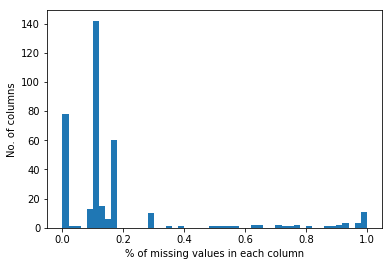

In [28]:
# plot a histogram to show the distribution of column NaN percentage in attributes
plt.hist(naCountsDf['na_percentage'],bins=50)
plt.xlabel('% of missing values in each column')
plt.ylabel('No. of columns')

In [29]:
# Remove columns with columns with more than 200,000 missing values from the dataset.
azdias_rm_col = [index for index,value in enumerate(naCounts_by_column) if value/azdias.shape[0] > 0.35]
azdias_rm_col = azdias.columns[azdias_rm_col]
azdias_column_filtered = azdias.drop(azdias_rm_col, axis=1)
print(azdias_rm_col)
print('Number of columns that have more than 35% missing values: ',len(azdias_rm_col))
print(azdias_column_filtered.shape)

Index(['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'EXTSEL992', 'GEBURTSJAHR',
       'KBA05_BAUMAX', 'KBA13_ANZAHL_PKW', 'KK_KUNDENTYP', 'MIN_GEBAEUDEJAHR',
       'TITEL_KZ'],
      dtype='object')
Number of columns that have more than 35% missing values:  38
(891221, 327)


Text(0, 0.5, 'No. of rows')

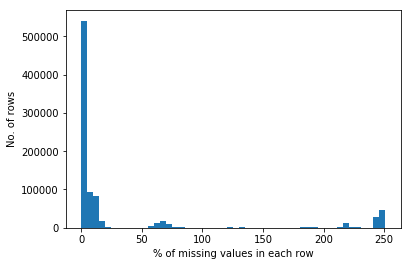

In [121]:
# plot a histogram to show the distribution of column NaN counts in attributes
plt.hist(azdias_column_filtered['naCounts_by_row'],bins=50)
plt.xlabel('% of missing values in each row')
plt.ylabel('No. of rows')

In [32]:
# remove the rows with more than 20% of missing values in each row.
azdias_column_row_filtered = azdias_column_filtered[azdias_column_filtered['naPercentage_by_row'] < 0.2] #extract rows with less than 30 missing data for further analysis
azdias_column_row_filtered = azdias_column_row_filtered.drop(['naCounts_by_row','naPercentage_by_row'], axis = 1)
print(azdias_column_row_filtered.shape)
rm_row_number = azdias_column_filtered.shape[0] - azdias_column_row_filtered.shape[0]
print("Number of rows removed:",rm_row_number)

(754092, 327)
Number of rows removed: 137129


#### 1.2.4 Re-engineer features
##### These features need to be handled specifically: 
- "CAMEO_DEUINTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables 
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west).
- "LP_STATUS_GROB" and "LP_FAMILIE_GROB" use different values to represent the same  meaning, so these values need to be combined

In [33]:
split_CAMEO_INTL_2015(azdias_column_row_filtered)
split_PRAEGENDE_JUGENDJAHRE(azdias_column_row_filtered)
engineer_LP_STATUS_GROB(azdias_column_row_filtered)
engineer_LP_FAMILIE_GROB(azdias_column_row_filtered)
print(azdias_column_row_filtered['CAMEO_INTL_2015_wealth'].value_counts())
print(azdias_column_row_filtered['CAMEO_INTL_2015_life'].value_counts())

5.0    214046
4.0    183131
2.0    176565
1.0    113555
3.0     63396
Name: CAMEO_INTL_2015_wealth, dtype: int64
1.0    233951
4.0    222038
5.0    111517
3.0    109702
2.0     73485
Name: CAMEO_INTL_2015_life, dtype: int64


In [34]:
#drop 'LP_LEBENSPHASE_FEIN' and 'CAMEO_DEU_2015' features as its information is redundant with other features in the table
azdias_column_row_filtered = azdias_column_row_filtered.drop(['LP_LEBENSPHASE_FEIN', 'CAMEO_DEU_2015'], axis=1)

# 'EINGEFUEGT_AM' seems like a datetime variable and doesn't provide valuable information to our purpose, so it is dropped
azdias_column_row_filtered.drop('EINGEFUEGT_AM', axis=1, inplace=True)

#### 1.2.5  Re-encode object features

In [35]:
#find categorical attribute in azdias_not_documented dataset, leave the ordinal variables unchanged
categorical_attribute = azdias_column_row_filtered.select_dtypes(include = 'object').columns.values
print(azdias_column_row_filtered.dtypes.value_counts())
print(azdias_column_row_filtered[categorical_attribute].describe())

float64    261
int64       64
object       2
dtype: int64
       D19_LETZTER_KAUF_BRANCHE OST_WEST_KZ
count                    589922      754092
unique                       35           2
top               D19_UNBEKANNT           W
freq                     184336      594391


In [36]:
feature_info_new = pd.read_csv('./feature_info_reorganize_manually_curated.csv', sep=',',\
                              index_col = 0)
feature_info_new.head()

,Attribute,Type
0,AGER_TYP,ordinal
1,AKT_DAT_KL,ordinal
2,ALTER_HH,ordinal
3,ALTER_KIND1,ordinal
4,ALTER_KIND2,ordinal


In [37]:
# Re-encode 'D19_LETZTER_KAUF_BRANCHE' and 'OST_WEST_KZ'.
#azdias_low_category_1 = azdias_low_category.drop(['CAMEO_DEU_2015'], axis=1) #CAMEO_DEU_2015 is dropped because it has too many categories and some
                                                        # might be overlap in one person
categorical_attribute = feature_info_new[feature_info_new['Type'] == 'categorical'].Attribute
attributes_after_filtered = azdias_column_row_filtered.columns.values.tolist() 
attribute_get_dummies = [value for value in categorical_attribute if value in attributes_after_filtered] #find the attributes that were kept in the filtered dataset

azdias_filtered_encoded = pd.get_dummies(azdias_column_row_filtered[attribute_get_dummies].astype(str))
azdias_filtered_encoded = pd.concat([azdias_column_row_filtered, azdias_filtered_encoded],axis=1)
azdias_filtered_encoded = azdias_filtered_encoded.drop(attribute_get_dummies, axis=1)
print(azdias_filtered_encoded.shape)

(754092, 422)


#### 1.2.6 Build a cleaning function for cleaning customer data

In [38]:
def clean_data(data, feat_info, azdias_rm_col, attribute_get_dummies):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    data['CAMEO_DEUG_2015'] = data['CAMEO_DEUG_2015'].replace({'X':np.nan}).astype(float)
    data['CAMEO_INTL_2015'] = data['CAMEO_INTL_2015'].replace({'XX':np.nan}).astype(float)
    data = replace_no_meaning_value_with_nan(data, feat_info)
    data = replace_unknown_value_with_nan(data, feat_info)
    data = remove_columns_rows_by_NA_counts(data, azdias_rm_col)
    
    split_CAMEO_INTL_2015(data)
    split_PRAEGENDE_JUGENDJAHRE(data)
    engineer_LP_STATUS_GROB(data)
    engineer_LP_FAMILIE_GROB(data)
    
    
    data.drop(['LP_LEBENSPHASE_FEIN','CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis=1, inplace = True)
    data_encoded = pd.get_dummies(data[attribute_get_dummies].astype(str))
    data_encoded = pd.concat([data, data_encoded],axis=1)
    data_encoded.drop(data_encoded[attribute_get_dummies], axis=1, inplace = True)
    return data_encoded

### 1.3 Primary component analysis (PCA) and K-means clustering of population dataset  
#### 1.3.1 Imputation, feature selection and scaling

In [39]:
# Fill in NaN values with the most frequent values in each column
imputer = SimpleImputer(missing_values=nan, strategy='most_frequent', verbose=0)
azdias_nan_filled = pd.DataFrame(imputer.fit_transform(azdias_filtered_encoded))
azdias_nan_filled.columns = azdias_filtered_encoded.columns

In [40]:
azdias_nan_filled.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_KATALOGNUTZER,CJT_TYP_1,...,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SHOPPER_TYP_nan,VERS_TYP_1.0,VERS_TYP_2.0,VERS_TYP_nan,ANREDE_KZ_1,ANREDE_KZ_2
0,9.0,18.0,21.0,0.0,12.0,3.0,6.0,8.0,1.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,9.0,17.0,17.0,0.0,7.0,3.0,2.0,4.0,2.0,4.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,13.0,13.0,0.0,2.0,2.0,4.0,2.0,3.0,2.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,20.0,14.0,0.0,3.0,4.0,2.0,6.0,3.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,10.0,10.0,0.0,2.0,2.0,6.0,8.0,5.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


/Users/maoshaohua/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1ab0d6c630>,
      dtype=object)

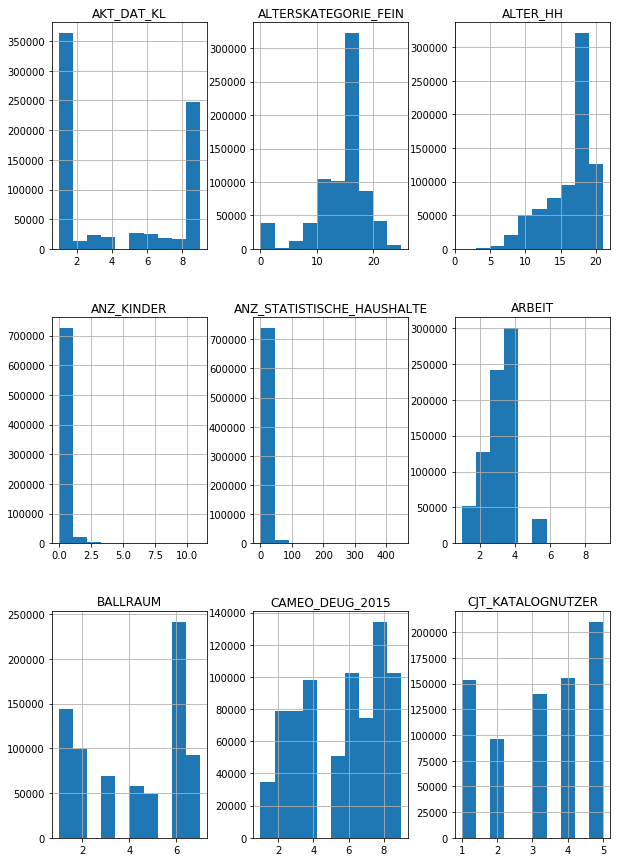

In [41]:
#Plot histogram to show the distribute of the count of Nan values in each column
azdias_nan_filled_histogram = azdias_nan_filled.iloc[:,0:9]
fig = plt.figure(figsize = (10,15))
ax = fig.gca()
azdias_nan_filled_histogram.hist(ax = ax)

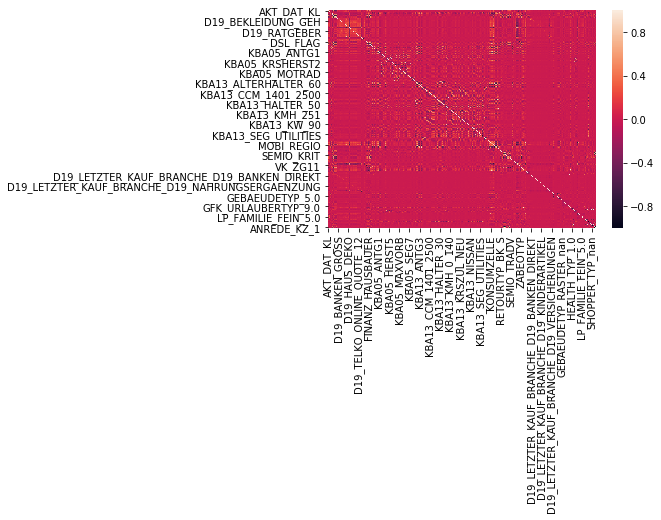

In [42]:
corr = azdias_nan_filled.corr()
sns.heatmap(corr)

In [43]:
#remove columns that have correlation higher than 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = azdias_nan_filled.columns[columns]
azdias_nan_filled_selected = azdias_nan_filled[selected_columns]


In [44]:
azdias_nan_filled_selected.shape

(754092, 404)

In [45]:
scaler = preprocessing.MinMaxScaler()
scaled_azdias = scaler.fit_transform(azdias_nan_filled_selected)
scaled_azdias = pd.DataFrame(data=scaled_azdias, columns = azdias_nan_filled_selected.columns)

/Users/maoshaohua/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a28678c18>,
      dtype=object)

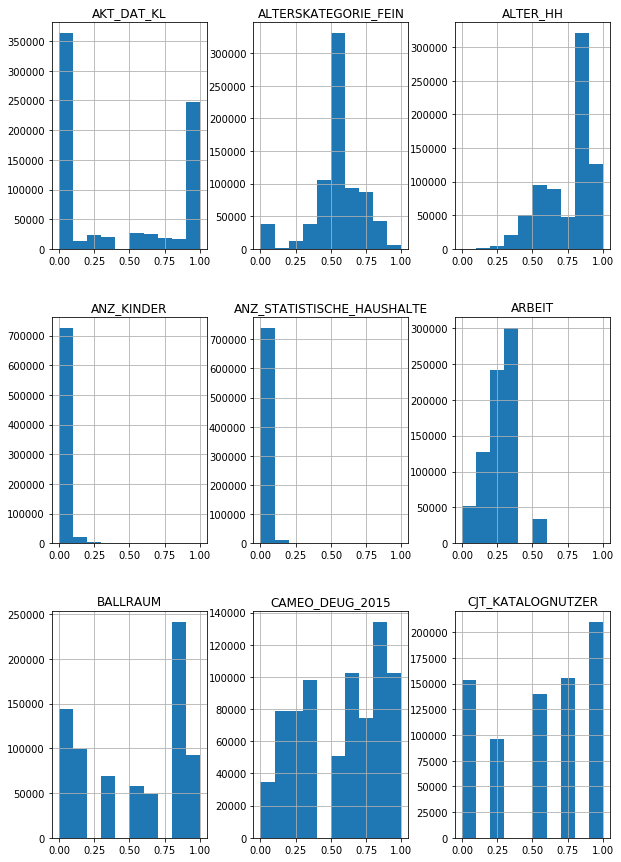

In [46]:
scaled_azdias_histogram = scaled_azdias.iloc[:,0:9]
#azdias_filtered_encoded_example.hist(bins=10)
fig = plt.figure(figsize = (10,15))
ax = fig.gca()
scaled_azdias_histogram.hist(ax = ax)

#### 1.3.2 Apply PCA

In [47]:
# Apply PCA to the data.
pca = PCA()
principalComponents = pca.fit_transform(scaled_azdias)
principalDf = pd.DataFrame(data=principalComponents)

Text(0.5, 0, 'Principle components')

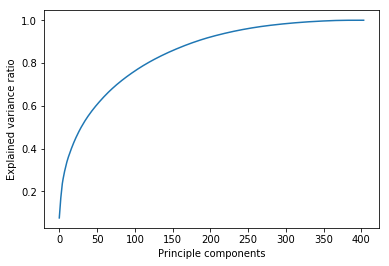

In [48]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained variance ratio')
plt.xlabel('Principle components')

(0.0, 0.08)

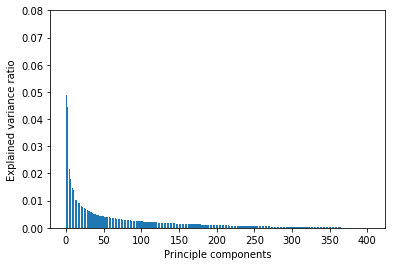

In [49]:
nComponents = principalDf.shape[1]
plt.bar(np.arange(nComponents),pca.explained_variance_ratio_)
#plt.bar([0:nComponents],pca.explained_variance_ratio_)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principle components')
plt.ylim(top = 0.08)

In [50]:
pca.explained_variance_ratio_[0:150]

array([0.07634557, 0.04900047, 0.04461422, 0.03387141, 0.03262901,
       0.0215283 , 0.0180862 , 0.01767516, 0.01513363, 0.01465338,
       0.01380577, 0.0120526 , 0.01118954, 0.01020411, 0.01005394,
       0.00989076, 0.00939935, 0.00923267, 0.00905176, 0.00844962,
       0.00842701, 0.00817517, 0.00763029, 0.00746995, 0.00731991,
       0.00725988, 0.00709377, 0.00680378, 0.00667619, 0.00642454,
       0.00611802, 0.00608831, 0.00600546, 0.00587254, 0.00572643,
       0.00558178, 0.0054705 , 0.00520611, 0.00511769, 0.00502299,
       0.00494586, 0.00485935, 0.00480409, 0.00472475, 0.00460222,
       0.00446792, 0.00442997, 0.00439818, 0.00434716, 0.00428396,
       0.00418666, 0.00410307, 0.00407927, 0.00403386, 0.00400227,
       0.00396522, 0.00393294, 0.00387025, 0.00381704, 0.0037511 ,
       0.00370183, 0.00367087, 0.0036514 , 0.00357256, 0.00354046,
       0.00352942, 0.0034431 , 0.00335524, 0.0033252 , 0.00329494,
       0.00326759, 0.00324474, 0.00319958, 0.00312838, 0.00312

In [51]:
# Investigate the variance accounted for by principal components.
variance_sum_150components = sum(pca.explained_variance_ratio_[:150])
print(variance_sum_150components)
variance_sum_100components = sum(pca.explained_variance_ratio_[:100])
print(variance_sum_100components)

0.8567891990839771
0.7605258339116404


(0.0, 0.08)

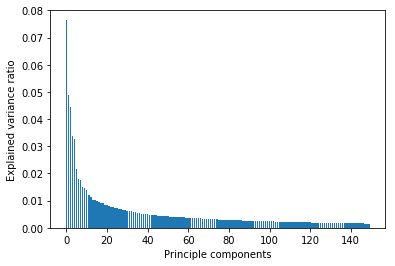

In [52]:
plt.bar(np.arange(150),pca.explained_variance_ratio_[0:150])
plt.ylabel('Explained variance ratio')
plt.xlabel('Principle components')
plt.ylim(top = 0.08)

In [53]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 150)
generalPC = pca.fit_transform(scaled_azdias)
principalDf = pd.DataFrame(data=generalPC)

#### Intepret principle componensts

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def mapWeight(df, component):
    pca_df = pd.DataFrame(pca.components_, columns=list(df.columns))
    pca_component = pd.DataFrame(pca_df.iloc[component])
    #print(pca_component.sort_values(component, ascending=False))
    pca_component = pca_component.sort_values(component, ascending=False)
    top_3_positively_correlated_component = pca_component.head(3)
    top_3_negatively_correlated_component = pca_component.tail(3)
    
    most_weighted_attribute = top_3_positively_correlated_component.append(top_3_negatively_correlated_component)\
    .rename(columns={component:'Weight'})
    most_weighted_attribute['PC_No'] = [component]*6
    
    return most_weighted_attribute
    #print(top_3_negatively_correlated_component)

In [55]:
mapWeight(scaled_azdias,0)

,Weight,PC_No
KBA13_BAUMAX,0.161345,0
KBA13_ANTG4,0.158295,0
PLZ8_ANTG4,0.154992,0
FINANZ_MINIMALIST,-0.153627,0
KBA05_ANTG1,-0.155725,0
LP_STATUS_FEIN,-0.182764,0


In [56]:
mapWeight(scaled_azdias,1)

,Weight,PC_No
FINANZ_VORSORGER,0.193881,1
CJT_TYP_4,0.187029,1
CJT_TYP_5,0.186522,1
CJT_TYP_2,-0.201552,1
CJT_TYP_1,-0.207911,1
FINANZ_SPARER,-0.220244,1


In [57]:
mapWeight(scaled_azdias,2)

,Weight,PC_No
OST_WEST_KZ_W,0.173693,2
KBA13_HERST_BMW_BENZ,0.161961,2
KBA13_SEG_SPORTWAGEN,0.144766,2
GREEN_AVANTGARDE_0,-0.131140,2
KBA13_SITZE_5,-0.145272,2
OST_WEST_KZ_O,-0.173693,2


### Interpretation of principal components

#### For the first principal components, the top weighted attributes are as following:  
-KBA13_BAUMAX: unknown  
-KBA13_ANTG4: unknown  
-PLZ8_ANTG4: number of >10 family houses in the PLZ8  


-FINANZ_MINIMALIST: financial typology-low financial interest  
-KBA05_ANTG1: number of 1-2 family houses in the cell  
-LP_STATUS_FEIN: social status fine


#### For the second principal components, the top weighted attributes are as following:   
-FINANZ_VORSORGER: financial typology-be prepared  
-CJT_TYP_4: unknown  
-CJT_TYP_5: unknown  

-CJT_TYP_2: unknown  
-CJT_TYP_1: unknown  
-FINANZ_SPARER: financial typology-money saver

#### For the third principal components, the top weighted attributes are as following:   
-OST_WEST_KZ_W: unknown 
-KBA13_HERST_BMW_BENZ: share of BMW & Mercedes Benz within the PLZ8  
-KBA13_SEG_SPORTWAGEN: share of sportscars within the PLZ8  

-GREEN_AVANTGARDE_0: unknown  
-KBA13_SITZE_5: number of cars with 5 seats in the PLZ8  
-OST_WEST_KZ_O: unknown


#### 1.3.3 Apply K-means clustering 

In [58]:
# Over a number of different cluster counts define a function to get the KMeans score. Run k-means clustering on the 
# data and compute the average within-cluster distances.
    
def kmeans_score(data, center):
    '''
    get SSE score for different number of clusters
    
    Keyword arguments:
    data: data sheet
    center: centers of clusters

    Returns:
    SSE score
    '''
    seed = np.random.RandomState(1)
    kmeans = KMeans(n_clusters=center, random_state=seed)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [59]:
'''# Investigate the change in within-cluster distance across number of clusters.
scores = []
centers = list(range(1,10))

for center in centers:
    scores.append(kmeans_score(principalDf, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')'''

"# Investigate the change in within-cluster distance across number of clusters.\nscores = []\ncenters = list(range(1,10))\n\nfor center in centers:\n    scores.append(kmeans_score(principalDf, center))\n    \nplt.plot(centers, scores, linestyle='--', marker='o', color='b')\nplt.xlabel('K')\nplt.ylabel('SSE')"

Text(0, 0.5, 'SSE')

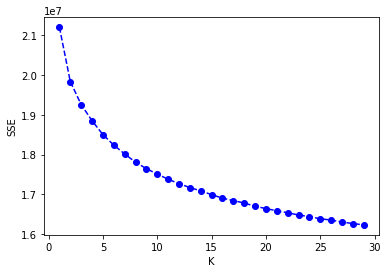

In [60]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []
centers = list(range(1,30))

for center in centers:
    scores.append(kmeans_score(principalDf, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')

In [61]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
seed = np.random.RandomState(1)
kmeans = KMeans(n_clusters=10, random_state=seed)
kmeansModel = kmeans.fit(principalDf)
generalPreds = kmeansModel.predict(principalDf)



In [62]:
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/maoshaohua/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [63]:
# Apply all steps to customer data
# Before that, we need to check the difference of columns between population and customer data and drop columns
# that were not included in population data
missing_in_customers = list(np.setdiff1d(azdias.columns, customers.columns))
print("These columns were in population data, but missed in customer data",missing_in_customers)
missing_in_azdias = list(np.setdiff1d(customers.columns,azdias.columns))
print("These columns were in customer data, but missed in population data", missing_in_azdias)

These columns were in population data, but missed in customer data []
These columns were in customer data, but missed in population data ['CUSTOMER_GROUP', 'LNR', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']


In [64]:
customers.drop(missing_in_azdias,axis=1, inplace=True)
customers.shape

(191652, 365)

In [65]:
#apply clean function to customer data
customers_clean = clean_data(customers,feature_info, azdias_rm_col, attribute_get_dummies)

In [66]:
customers_clean.shape

(136821, 420)

In [67]:
#check column consistence between azdias and customer data
missing_in_customers = list(np.setdiff1d(azdias_nan_filled_selected.columns, customers_clean.columns))
print(missing_in_customers)
missing_in_azdias = list(np.setdiff1d(customers_clean.columns,azdias_nan_filled_selected.columns))
print(missing_in_azdias)

['GEBAEUDETYP_5.0', 'GEBAEUDETYP_RASTER_nan']
['CAMEO_INTL_2015_wealth', 'D19_KONSUMTYP_MAX', 'D19_VERSAND_ONLINE_QUOTE_12', 'GFK_URLAUBERTYP_nan', 'GREEN_AVANTGARDE_1', 'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'KBA13_KMH_250', 'LP_FAMILIE_GROB_engineered', 'LP_STATUS_GROB_engineered', 'NATIONALITAET_KZ_nan', 'PLZ8_ANTG1', 'PLZ8_ANTG3', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'SHOPPER_TYP_nan', 'VERS_TYP_nan']


In [68]:
customers_clean['GEBAEUDETYP_5.0']=0
customers_clean['GEBAEUDETYP_RASTER_nan']=0

#fill in nan values
customer_nan_filled = pd.DataFrame(imputer.transform(customers_clean))
customer_nan_filled.columns = customers_clean.columns
#for other inconsistent columns, they are columns that have high correlation with each other.
customer_nan_filled.drop(missing_in_azdias,axis=1,inplace=True)

print(customer_nan_filled.shape)

(136821, 404)


In [69]:
missing_in_customers = list(np.setdiff1d(azdias_nan_filled_selected.columns, customer_nan_filled.columns))
print(missing_in_customers)
missing_in_azdias = list(np.setdiff1d(customer_nan_filled.columns,azdias_nan_filled_selected.columns))
print(missing_in_azdias)

[]
[]


In [70]:
customer_nan_filled.columns

Index(['AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'BALLRAUM', 'CAMEO_DEUG_2015',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1',
       ...
       'SHOPPER_TYP_0.0', 'SHOPPER_TYP_1.0', 'SHOPPER_TYP_2.0',
       'SHOPPER_TYP_3.0', 'VERS_TYP_1.0', 'VERS_TYP_2.0', 'ANREDE_KZ_1',
       'ANREDE_KZ_2', 'GEBAEUDETYP_5.0', 'GEBAEUDETYP_RASTER_nan'],
      dtype='object', length=404)

In [71]:
#scaling
customer_scaled = scaler.transform(customer_nan_filled)
customer_scaled = pd.DataFrame(data=customer_scaled, columns = customer_nan_filled.columns)

# Apply PCA to the data.
customerPC = pca.transform(customer_scaled)
customerPrincipalDf = pd.DataFrame(data=customerPC)

# Fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
customerPreds = kmeansModel.predict(customerPrincipalDf)

In [72]:
results = pd.DataFrame([customerPrincipalDf.index,customerPreds]).T
print(results.head())
print(results.shape)
print(results[1].value_counts().sum())

   0  1
0  0  9
1  1  1
2  2  9
3  3  8
4  4  3
(136821, 2)
136821


### 1.5 Compare customer cluster to population cluster and obtain the demographic characteristics of potential customers

In [73]:
def get_pct_of_clusters(preds):
    '''
    get the percentage of each cluster in dataset
    
    Keyword arguments:
    preds: predicted cluster value
    
    Returns:
    percentage of each cluster in dataset
    '''
    
    preds = list(preds)
    count_of_each_cluster = {x:preds.count(x) for x in set(preds)}
    cluster_summarize = pd.DataFrame.from_dict(count_of_each_cluster, orient='index',columns = ['cluster_count'])
    cluster_summarize['cluster_pct'] = cluster_summarize['cluster_count']/sum(cluster_summarize['cluster_count'])
    return cluster_summarize


In [74]:
general_cluster_summarize = get_pct_of_clusters(generalPreds)
customer_cluster_summarize = get_pct_of_clusters(customerPreds)

[Text(0, 0.5, 'Ratio of cluster frequency'),
 Text(0.5, 0, 'Cluster'),
 Text(0.5, 1.0, 'Customers/general')]

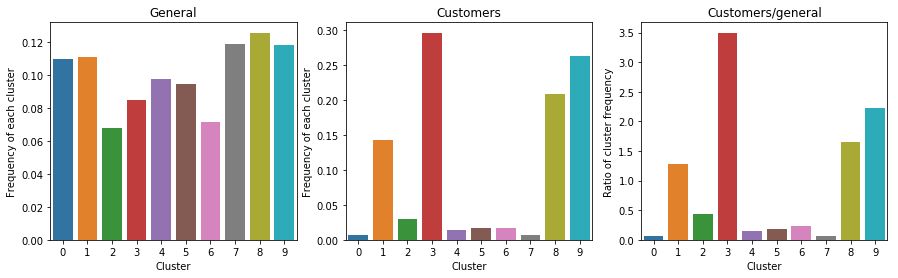

In [75]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
plt.figure(figsize=(15, 4))
plt.subplot(131)
plot1 = sns.barplot(x=general_cluster_summarize.index, y=general_cluster_summarize['cluster_pct'])
plot1.set(ylabel="Frequency of each cluster", xlabel="Cluster", title = 'General')
plt.subplot(132)
plot2 = sns.barplot(x=customer_cluster_summarize.index, y=customer_cluster_summarize['cluster_pct'])
plot2.set(ylabel="Frequency of each cluster", xlabel="Cluster", title = 'Customers')
plt.subplot(133)
plot2 = sns.barplot(x=customer_cluster_summarize.index, y=customer_cluster_summarize['cluster_pct']/general_cluster_summarize['cluster_pct'])
plot2.set(ylabel="Ratio of cluster frequency", xlabel="Cluster", title = 'Customers/general')

In [76]:
def get_top_attribute_in_principal_components_in_cluster(cluster, no_of_PC):
    '''
    For each cluster, find the top primary components and obtain the most weighted attributes in these components
    
    Keyword arguments:
    cluster: cluster number
    no_of_PC: number of pricinpal components we want to look at

    Returns:
    A list of most weighted attributes in the principal components we selected
    '''
    topPC_index = pd.Series(centers[cluster]).sort_values(ascending=False).head(no_of_PC).index.tolist()
    top_weighted_attribute_df = pd.DataFrame()
    for i in topPC_index:
        top_weighted_attribute_in_PC = mapWeight(pd.DataFrame(customer_scaled),i)
        top_weighted_attribute_df = top_weighted_attribute_df.append(top_weighted_attribute_in_PC)
    return top_weighted_attribute_df

In [77]:
def get_original_value_of_cluster_center(cluster,no_of_PC, feature_info):
    '''
    Get the original value and its meaning in the most weighted attributes in the cluster
    
    Keyword arguments:
    cluster: cluster number
    no_of_PC: number of pricinpal components we want to look at
    feature_info: the spreadsheet records the description and meaning of each attribute

    Returns:
    A dataframe with the attribute values and meaning
    '''
    top_weighted_attribute_df = get_top_attribute_in_principal_components_in_cluster(cluster,no_of_PC)
    top_weighted_attributes = top_weighted_attribute_df.index.values.tolist()
    Attribute_values_in_cluster = pd.DataFrame(columns = ['Original_value'], index = top_weighted_attributes)

    for i in top_weighted_attributes:
        Attribute_values_in_cluster.loc[i] = round(inversed_centers.loc[cluster, i].astype(float))
        
    Attribute_values_in_cluster.reset_index(level=0, inplace=True)
    Attribute_interpretation_in_cluster = pd.merge(Attribute_values_in_cluster, feature_info, how='left', \
                 left_on = ['index', 'Original_value'], \
                 right_on = ['Attribute', 'Value']).drop(['Value','Attribute'], axis = 1)

    #return(Attribute_values_in_cluster['Original_value'].astype(float).round(0)) 
    return(Attribute_interpretation_in_cluster)

In [116]:
#Cluster 3 is the most overrepresented cluster in customers, indicating that these clusters in population are more likely to be 
#potential customers.
centers = np.array(kmeansModel.cluster_centers_)
inversed_centers = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(centers)), 
                               columns = customer_scaled.columns)
get_top_attribute_in_principal_components_in_cluster(3,2)

,Weight,PC_No
SHOPPER_TYP_1.0,0.173693,2
KBA13_HERST_BMW_BENZ,0.161961,2
KBA13_SEG_SPORTWAGEN,0.144766,2
HEALTH_TYP_2.0,-0.131140,2
KBA13_SITZE_5,-0.145272,2
SHOPPER_TYP_0.0,-0.173693,2
FINANZ_VORSORGER,0.193881,1
CJT_TYP_4,0.187029,1
CJT_TYP_5,0.186522,1
CJT_TYP_2,-0.201552,1


In [117]:
#print out Demographic characteristics of Cluster 3 in customer dataset
print('\033[1m' + 'Demographic characteristics of Cluster 3 in customer' + '\033[0m')
get_original_value_of_cluster_center(3, 2, feature_info)

Demographic characteristics of Cluster 3 in customer


,index,Original_value,Description,Meaning
0,SHOPPER_TYP_1.0,1,NaN,NaN
1,KBA13_HERST_BMW_BENZ,4,share of BMW & Mercedes Benz within the PLZ8,high
2,KBA13_SEG_SPORTWAGEN,4,share of sportscars within the PLZ8,high
3,HEALTH_TYP_2.0,0,NaN,NaN
4,KBA13_SITZE_5,2,number of cars with 5 seats in the PLZ8,low
5,SHOPPER_TYP_0.0,0,NaN,NaN
6,FINANZ_VORSORGER,4,financial typology: be prepared,low
7,CJT_TYP_4,4,NaN,NaN
8,CJT_TYP_5,4,NaN,NaN
9,CJT_TYP_2,2,NaN,NaN


### Interpretation of demographic characteristics of cluster 3 population  
Person in this cluster are most likely having good financial status because their owning of high-end cars and they are also mostly likely to be money saver. This group of population should be targeted in the market compaign. 

In [118]:
#Cluster 0, 7 are the most underpresented clusters in customers, indicating that these clusters in population are unlikely
#to become potential customers, which will be excluded from the marketing campaign
print('\033[1m' + 'Demographic characteristics of Cluster 0 in customer' + '\033[0m')
get_original_value_of_cluster_center(0, 2, feature_info)


Demographic characteristics of Cluster 0 in customer


,index,Original_value,Description,Meaning
0,GEBAEUDETYP_5.0,1,NaN,NaN
1,SEMIO_VERT,6,affinity indicating in what way the person is ...,very low affinity
2,SEMIO_KULT,6,affinity indicating in what way the person is ...,very low affinity
3,SEMIO_DOM,3,affinity indicating in what way the person is ...,high affinity
4,SEMIO_KAEM,2,affinity indicating in what way the person is ...,very high affinity
5,GEBAEUDETYP_RASTER_nan,0,NaN,NaN
6,GEBAEUDETYP_RASTER_5.0,1,NaN,NaN
7,KBA13_KW_30,1,share of cars up to 30 KW engine power - PLZ8,very low
8,KBA13_KMH_140,3,share of cars with max speed between 110 km/h ...,average
9,KBA13_CCM_1401_2500,3,NaN,NaN


In [120]:
print('\033[1m' + 'Demographic characteristics of Cluster 7 in customer' + '\033[0m')
get_original_value_of_cluster_center(7, 2,feature_info)

Demographic characteristics of Cluster 7 in customer


,index,Original_value,Description,Meaning
0,KBA13_BAUMAX,1,NaN,NaN
1,KBA13_ANTG4,0,NaN,NaN
2,PLZ8_ANTG4,0,number of >10 family houses in the PLZ8,none
3,FINANZ_MINIMALIST,2,financial typology: low financial interest,high
4,KBA05_ANTG1,2,number of 1-2 family houses in the cell,average share of 1-2 family homes
5,LP_STATUS_FEIN,4,social status fine,villagers
6,KBA05_MAXHERST_1.0,0,NaN,NaN
7,ANREDE_KZ_1,1,NaN,NaN
8,KBA13_ALTERHALTER_61,3,share of car owners elder than 61 within the PLZ8,average
9,KBA13_ALTERHALTER_45,3,share of car owners between 31 and 45 within t...,average


### Interpretation of demographic characteristics of cluster 0 and 7 population  
Cluster 0 is hard to interprete because it seems to relate to some social behaviors and personalities. 
However, we can clearly see that cluster 7 is a group of people with low income, and people living in 
rural area and possily old and retired. 


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [82]:
import sys
!{sys.executable} -m pip install xgboost

In [83]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from time import time
import operator
import warnings
warnings.filterwarnings('ignore')

### 2.1 Define all functions that will be used in this project 

In [84]:
def create_pipeline(clf):
    '''
    Create a pipeline to do the imputation, scaling and classfification
    
    Keyword arguments:
    clf: classifier
    
    Returns:
    Pipeline
    '''
    
    return Pipeline([
        ('imp', Imputer()),
        ('scale', StandardScaler()),
        ('clf', clf)
    ])

In [85]:
def model_evaluation(clf, X, y):
    '''
    Split data into training and test dataset, execute training and testing of the model
    
    Keyword arguments:
    clf: classifier
    X: data in all features
    y: response
    
    Returns:
    ROC scores of the model
    '''
    
    start = time()
    
    pipeline = create_pipeline(clf)
    scores = []

    for train_index, test_index in skf.split(X, y):
        # Split the data into training and testing datasets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # model training on the training dataset
        pipeline.fit(X_train, y_train)

        # Prediction on the test dataset
        y_pred = pipeline.predict(X_test)
        
        # Obtain the ROC score of the predicted results vs. response
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        
    end = time()
    print("model_evaluation executed in {} seconds.".format(end - start))
    return scores

In [86]:
def get_feature_respond(data, feature_info):
    '''
    clean data and split data into two sections: features and labels
    
    Keyword arguments:
    data: dataset
    feature_info: feature spreadsheet 
    
    Returns:
    Features and labels 
    '''

    y = data.RESPONSE
    
    X = data.drop(['RESPONSE', 'LNR'], axis = 1)
    X = clean_data(X, feature_info,azdias_rm_col,attribute_get_dummies)
    
    deletedRowIndexs = list(set(y.index.values.tolist()) - set(X.index.values.tolist()))
    y = y.drop(deletedRowIndexs, axis=0)
    
    return X, y

In [87]:
def doGridSearch(clf, prarm):
    '''
    Perform grid search to optimize the parameters
    
    Keyword arguments:
    clf: classifier
    prarm: paramters
    
    Returns:
    Model fitted with optimized paramters
    '''
    start = time()
    
    gsearch = GridSearchCV(estimator = create_pipeline(clf),
                       param_grid = param, scoring='roc_auc', n_jobs=-1, iid=False, cv=5)
    gsearch.fit(X,y)
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    end = time()
    print("doGridSearch executed in {} seconds.".format(end - start))

### 2.2 Split data into training and testing data 

In [88]:
#split data into 5 folds training and testing data
skf = StratifiedKFold(n_splits=5, random_state=30, shuffle=True)

In [89]:
mailout_train = pd.read_csv('./Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [130]:
print(mailout_train.shape)
print(mailout_train['RESPONSE'].value_counts())
(mailout_train.RESPONSE == 1).mean()

(42962, 367)
0    42430
1      532
Name: RESPONSE, dtype: int64


0.012383036171500396

In [91]:
start = time()
#splite data into features and response
X, y = get_feature_respond(mailout_train, feature_info)

end = time()
print("get_feature_respond executed in {} seconds.".format(end - start))
X.shape, y.shape

get_feature_respond executed in 8.888243198394775 seconds.


((34400, 420), (34400,))

### 2.3 Select classifers and train models with default parameters

In [92]:
# We have tried classifiers and the classification results are not good, so instead we used regressors to make classification
clf_candidates = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=30),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=30),
    "XGBRegressor": XGBRegressor(random_state=30, objective = 'binary:logistic'),
}

In [93]:
start = time()
# use default parameters to execute the regressors and obtain the AUC score for model evaluation
clf_scores_dict = {}

for name, clf in clf_candidates.items():
    clf_scores_dict[name] = model_evaluation(clf, X, y)
    
end = time()
print("get clf_scores_dict executed in {} seconds.".format(end - start))

model_evaluation executed in 148.57685708999634 seconds.
model_evaluation executed in 43.52824783325195 seconds.
model_evaluation executed in 188.17693614959717 seconds.
get clf_scores_dict executed in 380.32183623313904 seconds.


In [94]:
clf_scores_df = pd.DataFrame(clf_scores_dict)
clf_scores_df.columns = list(clf_candidates.keys())
clf_scores_df

,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor
0,0.771542,0.752002,0.773727
1,0.809774,0.792879,0.810515
2,0.757817,0.762194,0.745195
3,0.805594,0.790422,0.786660
4,0.729367,0.732075,0.744325


In [95]:
clf_scores_df.describe()

,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor
count,5.000000,5.000000,5.000000
mean,0.774819,0.765914,0.772084
std,0.033670,0.025885,0.028221
min,0.729367,0.732075,0.744325
25%,0.757817,0.752002,0.745195
50%,0.771542,0.762194,0.773727
75%,0.805594,0.790422,0.786660
max,0.809774,0.792879,0.810515


### 2.4 Fine tune parameters
The mean ROC score of the three classifiers show that the performance of GradientBoostingRegressor and XGBRegressor are a little better than AdaBoostRegressor; thus in the next section, we fine tune the parameters in these two models to improve the results.    
Because it took too long time to tune all parameters at the same time, I split the parameters and tuned them separately. The optimal parameters will be feed in the next tuning. 

#### 2.4.1 Fine tune parameters for GradientBoostingRegressor


In [96]:
param = {
    'clf__max_depth':range(3,10,1),
    'clf__min_child_weight':range(1,6,1)
}

clf = XGBRegressor(random_state = 30,
                    objective = 'binary:logistic',
                    scale_pos_weight = 1)

doGridSearch(clf, param)

{'clf__max_depth': 8, 'clf__min_child_weight': 1}
0.7766476551832072
doGridSearch executed in 4245.077302932739 seconds.


In [97]:
param = {
    'clf__gamma': [i/10.0 for i in range(0,5)]
}

clf = XGBRegressor(random_state=30, 
                    max_depth = 8,
                    min_child_weight = 1,
                    objective = 'binary:logistic',
                    scale_pos_weight = 1)

doGridSearch(clf, param)

{'clf__gamma': 0.0}
0.7766476551832072
doGridSearch executed in 868.498517036438 seconds.


In [98]:
param = {
    'clf__subsample':[i/100.0 for i in range(75,90,5)],
    'clf__colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

clf = XGBRegressor(random_state=30, 
                    max_depth = 8,
                    gamma = 0.0,
                    min_child_weight = 1,
                    objective = 'binary:logistic',
                    scale_pos_weight = 1)

doGridSearch(clf, param)

{'clf__colsample_bytree': 0.85, 'clf__subsample': 0.75}
0.77959894673451
doGridSearch executed in 1178.0465908050537 seconds.


In [99]:
param = {
    'clf__reg_alpha':[i/10.0 for i in range(1,10)]
}

clf = XGBRegressor(random_state=30, 
                    max_depth = 8,
                    gamma = 0.0,
                    min_child_weight = 1,
                    subsample = 0.75,
                    colsample_bytree = 0.85,
                    objective = 'binary:logistic',
                    scale_pos_weight = 1)

doGridSearch(clf, param)

{'clf__reg_alpha': 0.3}
0.7777947395879947
doGridSearch executed in 1210.2953851222992 seconds.


In [100]:
clf = XGBRegressor(random_state=30, 
                    max_depth = 8,
                    gamma = 0.0,
                    min_child_weight = 1,
                    subsample = 0.75,
                    colsample_bytree = 0.85,
                    objective = 'binary:logistic',
                    reg_alpha = 0.3,
                    scale_pos_weight = 1)
scores = model_evaluation(clf, X, y)
np.array(scores).mean()

model_evaluation executed in 336.95400977134705 seconds.


0.7718603170292754

#### 2.4.2 Fine tune parameters for GradientBoostingRegressor

In [101]:
#n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
#learning_rates = [0.5, 0.25, 0.1, 0.05, 0.01, 0.005]

n_estimators = [4, 8, 16, 32, 64, 100]
learning_rates = [0.5, 0.25, 0.1, 0.05, 0.01]

param = {
    'clf__n_estimators': n_estimators,
    'clf__learning_rate': learning_rates
}
clf = GradientBoostingRegressor(random_state = 30)
doGridSearch(clf, param)

{'clf__learning_rate': 0.25, 'clf__n_estimators': 16}
0.7772629239188947
doGridSearch executed in 807.4370279312134 seconds.


In [102]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

param = {
    'clf__max_depth': max_depths,
    'clf__min_samples_split': min_samples_splits
}
clf = GradientBoostingRegressor(random_state = 30,
                               learning_rate = 0.25,
                               n_estimators = 16)
doGridSearch(clf, param)

{'clf__max_depth': 9.0, 'clf__min_samples_split': 0.5}
0.7852073761442566
doGridSearch executed in 3923.1991040706635 seconds.


In [103]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

param = {
    'clf__min_samples_leaf': min_samples_leafs,
}

clf = GradientBoostingRegressor(random_state = 30,
                               learning_rate = 0.25,
                               n_estimators = 16,
                               min_samples_split = 0.5,
                               max_depth = 9)
doGridSearch(clf, param)

{'clf__min_samples_leaf': 0.1}
0.7824276602346764
doGridSearch executed in 27.998707056045532 seconds.


In [104]:
clf = GradientBoostingRegressor(random_state = 30,
                               learning_rate = 0.25,
                               n_estimators = 16,
                               min_samples_split = 0.5,
                               max_depth = 9,
                               min_samples_leaf = 0.1)

scores = model_evaluation(clf, X, y)
np.array(scores).mean()

model_evaluation executed in 15.605759859085083 seconds.


0.7795357991539623

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [105]:
mailout_test = pd.read_csv('./Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [133]:
print(mailout_test.shape)
mailout_test.head()

(42833, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2.0,1.0,7.0,NaN,NaN,NaN,NaN,6.0,NaN,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2.0,9.0,16.0,NaN,NaN,NaN,NaN,11.0,NaN,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,NaN,7.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1.0,1.0,21.0,NaN,NaN,NaN,NaN,13.0,NaN,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [106]:
X_test_clean = clean_data(mailout_test, feature_info, azdias_rm_col, attribute_get_dummies)

In [107]:
print(X_test_clean.shape)
X_withoutLNR = X_test_clean.drop(['LNR'], axis = 1)

(34431, 421)


In [108]:
X_withoutLNR.shape

(34431, 420)

In [109]:
pipeline = create_pipeline(clf)
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.25, loss='ls', max_depth=9...=30, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))])

In [110]:
predictions = pipeline.predict(X_withoutLNR)
predictions = pd.DataFrame({'Response':predictions})
predictions['LNR'] = X_test_clean['LNR'].tolist()
predictions = predictions[['LNR', 'Response']]
print(predictions.head())

    LNR  Response
0  1754  0.031602
1  1770  0.035004
2  1465  0.003245
3  1470  0.002833
4  1478  0.001253


Text(0, 0.5, 'No. of participants')

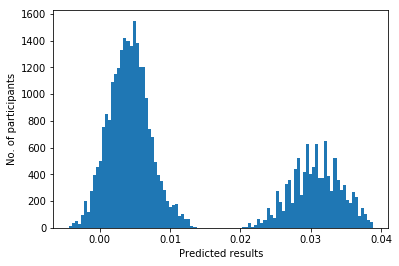

In [138]:
# plot a histogram to show the distribution of predicted probabilities
plt.hist(predictions['Response'],bins=100)
plt.xlabel('Predicted results')
plt.ylabel('No. of participants')

In [137]:
print(predictions[predictions['Response'] > 0.02].shape[0])
print(predictions[predictions['Response'] < 0.02].shape[0])

10623
23808


In [111]:
predictions.to_csv('predicted_results_for_Kaggle_compettion.csv')